In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, f1_score,
    accuracy_score, mean_absolute_error,
    mean_squared_error, r2_score
)
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, learning_curve
)

# Estilo profesional
plt.rcParams['figure.facecolor'] = '#0f1117'
plt.rcParams['axes.facecolor']   = '#1a1d2e'
plt.rcParams['axes.labelcolor']  = 'white'
plt.rcParams['xtick.color']      = 'white'
plt.rcParams['ytick.color']      = 'white'
plt.rcParams['text.color']       = 'white'
plt.rcParams['grid.color']       = '#2d2d2d'
plt.rcParams['grid.alpha']       = 0.4

# ✅ Rutas
PROJECT_ROOT = os.path.join(
    r"C:\Users\matup\OneDrive\Documentos",
    "sistema_de_Predicción_de_Fallos_en_Última Milla"
)
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed",
                 "dataset_limpio.csv")
MODELS_PATH    = os.path.join(PROJECT_ROOT, "outputnts", "models")
FIGURES_PATH   = os.path.join(PROJECT_ROOT, "outputnts", "figures")
REPORTS_PATH   = os.path.join(PROJECT_ROOT, "outputnts", "reports")

os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

# ✅ Cargar modelos guardados
modelo_bin   = joblib.load(os.path.join(MODELS_PATH,
               "modelo1_clasificacion_binaria.pkl"))
modelo_multi = joblib.load(os.path.join(MODELS_PATH,
               "modelo2_clasificacion_multiclase.pkl"))
modelo_reg   = joblib.load(os.path.join(MODELS_PATH,
               "modelo3_regresion_costo.pkl"))
scaler       = joblib.load(os.path.join(MODELS_PATH, "scaler.pkl"))
encoders     = joblib.load(os.path.join(MODELS_PATH, "encoders.pkl"))
cols_escalar = joblib.load(os.path.join(MODELS_PATH, "cols_escalar.pkl"))
features_reg = joblib.load(os.path.join(MODELS_PATH,
               "features_regresion.pkl"))

print("✅ Todos los modelos cargados correctamente")
print(f"   → modelo1_clasificacion_binaria.pkl")
print(f"   → modelo2_clasificacion_multiclase.pkl")
print(f"   → modelo3_regresion_costo.pkl")

✅ Todos los modelos cargados correctamente
   → modelo1_clasificacion_binaria.pkl
   → modelo2_clasificacion_multiclase.pkl
   → modelo3_regresion_costo.pkl


In [2]:
from sklearn.model_selection import train_test_split

# ✅ Cargar dataset
df = pd.read_csv(DATA_PROCESSED)
df['fecha_envio'] = pd.to_datetime(df['fecha_envio'])

# ── Mismas exclusiones que en el notebook de modelado ─────
excluir = [
    'shipment_id', 'fecha_envio', 'chofer',
    'entrega_exitosa', 'estado', 'estado_encoded', 'demora_horas',
    'diferencia_tiempo', 'llego_tarde', 'tiempo_real_horas',
    'provincia', 'zona', 'tipo_cliente', 'transportista',
    'clima', 'evento_especial', 'estacion', 'motivo_fallo',
    'dia_semana'
]
features = [c for c in df.columns if c not in excluir]
features = [c for c in features if c in df.columns]

X            = df[features].fillna(0)
y_binario    = df['entrega_exitosa']
y_multiclase = df['estado_encoded']
y_regresion  = df['costo_envio']

# ── Split idéntico al notebook de modelado ────────────────
X_train, X_test, y_bin_train, y_bin_test = train_test_split(
    X, y_binario, test_size=0.20,
    random_state=42, stratify=y_binario)

_, _, y_multi_train, y_multi_test = train_test_split(
    X, y_multiclase, test_size=0.20,
    random_state=42, stratify=y_multiclase)

_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_regresion, test_size=0.20, random_state=42)

features_reg_clean = [f for f in features_reg if f in X.columns]
X_test_reg  = X_test[features_reg_clean]
X_train_reg = X_train[features_reg_clean]

# Generar predicciones
y_pred_bin   = modelo_bin.predict(X_test)
y_prob_bin   = modelo_bin.predict_proba(X_test)[:, 1]
y_pred_multi = modelo_multi.predict(X_test)
y_pred_reg   = modelo_reg.predict(X_test_reg)

nombres_estados = encoders['estado'].classes_

print("✅ Datos de test reconstruidos")
print(f"   Test size : {X_test.shape[0]:,} registros")
print(f"   Features  : {len(features)}")

✅ Datos de test reconstruidos
   Test size : 100,000 registros
   Features  : 22


📊 EVALUACIÓN MODELO 1 — CLASIFICACIÓN BINARIA

🎯 Métricas finales:
   Accuracy  : 0.9914 (99.14%)
   F1-Score  : 0.9915
   AUC-ROC   : 0.9998


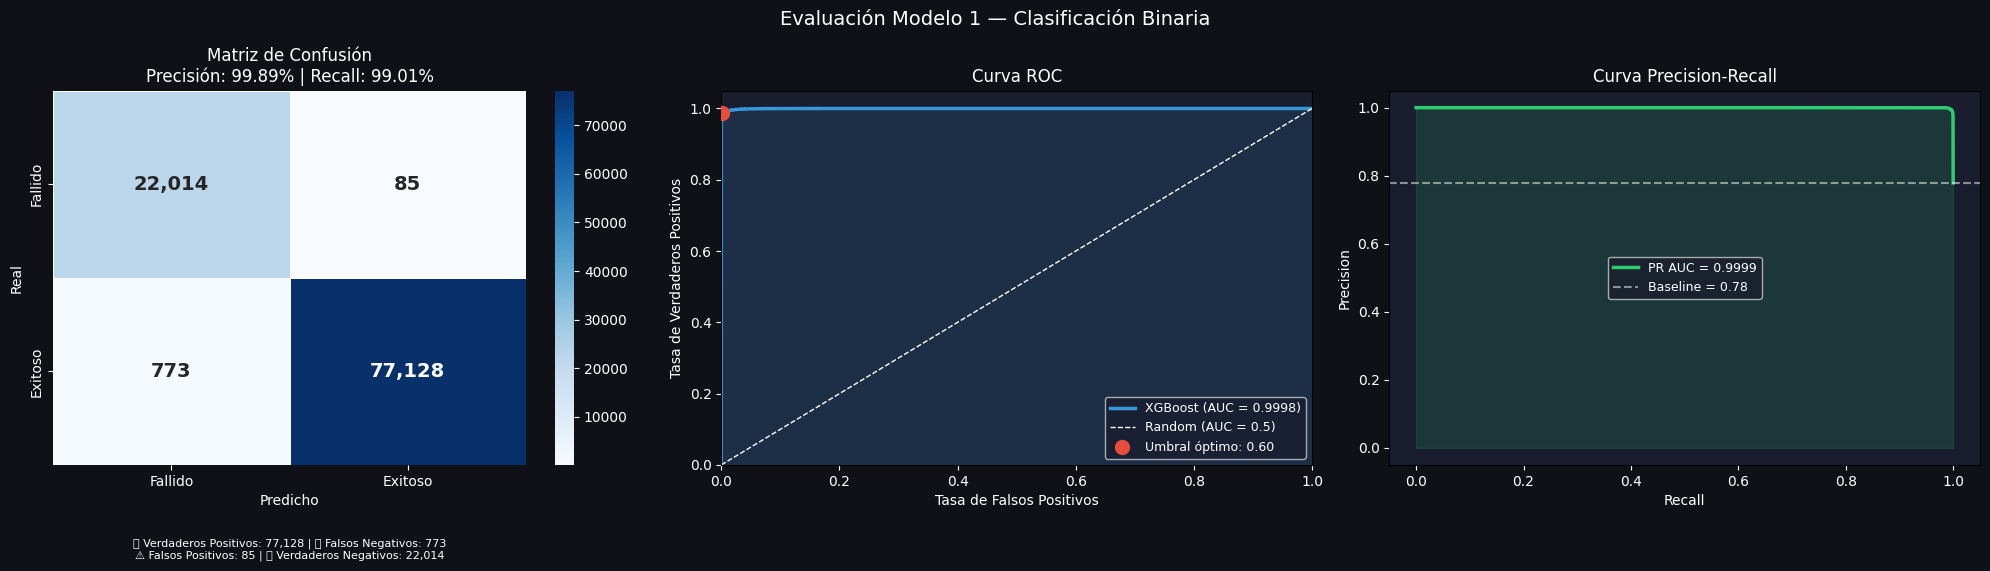

✅ Guardado: eval_01_modelo_binario.png


In [3]:
print("=" * 60)
print("📊 EVALUACIÓN MODELO 1 — CLASIFICACIÓN BINARIA")
print("=" * 60)

acc_bin = accuracy_score(y_bin_test, y_pred_bin)
f1_bin  = f1_score(y_bin_test, y_pred_bin, average='weighted')
auc_bin = roc_auc_score(y_bin_test, y_prob_bin)

print(f"\n🎯 Métricas finales:")
print(f"   Accuracy  : {acc_bin:.4f} ({acc_bin:.2%})")
print(f"   F1-Score  : {f1_bin:.4f}")
print(f"   AUC-ROC   : {auc_bin:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Evaluación Modelo 1 — Clasificación Binaria', fontsize=14)

# ── Matriz de confusión con métricas ─────────────────────
cm = confusion_matrix(y_bin_test, y_pred_bin)
tn, fp, fn, tp = cm.ravel()

sns.heatmap(cm, annot=True, fmt=',', cmap='Blues',
            ax=axes[0], linewidths=0.5,
            xticklabels=['Fallido', 'Exitoso'],
            yticklabels=['Fallido', 'Exitoso'],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title(
    f'Matriz de Confusión\n'
    f'Precisión: {tp/(tp+fp):.2%} | Recall: {tp/(tp+fn):.2%}')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

# Agregar anotaciones
axes[0].text(0.5, -0.25,
    f'✅ Verdaderos Positivos: {tp:,} | ❌ Falsos Negativos: {fn:,}\n'
    f'⚠️ Falsos Positivos: {fp:,} | ✅ Verdaderos Negativos: {tn:,}',
    ha='center', transform=axes[0].transAxes, fontsize=8)

# ── Curva ROC ─────────────────────────────────────────────
fpr, tpr, thresholds = roc_curve(y_bin_test, y_prob_bin)
roc_auc_val          = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='#3498db', lw=2.5,
             label=f'XGBoost (AUC = {roc_auc_val:.4f})')
axes[1].plot([0, 1], [0, 1], 'w--', lw=1, label='Random (AUC = 0.5)')
axes[1].fill_between(fpr, tpr, alpha=0.15, color='#3498db')

# Punto óptimo
optimal_idx   = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]
axes[1].scatter(fpr[optimal_idx], tpr[optimal_idx],
                color='#e74c3c', s=100, zorder=5,
                label=f'Umbral óptimo: {optimal_thresh:.2f}')

axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curva ROC')
axes[1].legend(fontsize=9)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.05])

# ── Curva Precision-Recall ────────────────────────────────
precision, recall, _ = precision_recall_curve(y_bin_test, y_prob_bin)
pr_auc = auc(recall, precision)

axes[2].plot(recall, precision, color='#2ecc71', lw=2.5,
             label=f'PR AUC = {pr_auc:.4f}')
axes[2].fill_between(recall, precision, alpha=0.15, color='#2ecc71')
axes[2].axhline(y=y_bin_test.mean(), color='white',
                linestyle='--', alpha=0.5,
                label=f'Baseline = {y_bin_test.mean():.2f}')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Curva Precision-Recall')
axes[2].legend(fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "eval_01_modelo_binario.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: eval_01_modelo_binario.png")

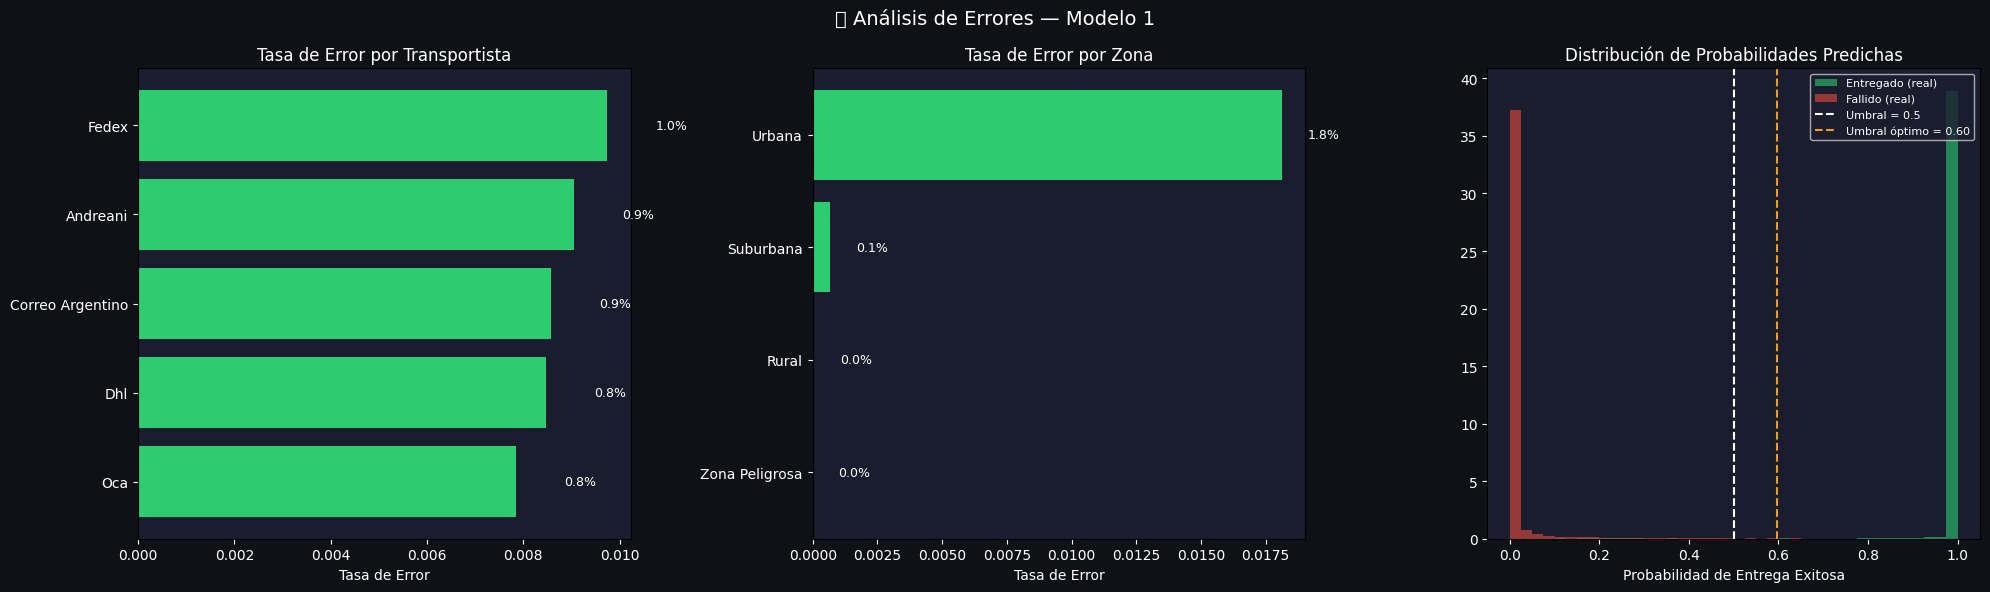

✅ Guardado: eval_02_errores_modelo1.png


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('🔍 Análisis de Errores — Modelo 1', fontsize=14)

# ── Agregar predicciones al dataframe de test ─────────────
df_test = X_test.copy()
df_test['real']      = y_bin_test.values
df_test['predicho']  = y_pred_bin
df_test['prob']      = y_prob_bin
df_test['error']     = (df_test['real'] != df_test['predicho']).astype(int)

df_test['provincia_orig']      = df.loc[X_test.index, 'provincia'].values
df_test['transportista_orig']  = df.loc[X_test.index, 'transportista'].values
df_test['zona_orig']           = df.loc[X_test.index, 'zona'].values
df_test['evento_orig']         = df.loc[X_test.index, 'evento_especial'].values

# ── Tasa de error por transportista ──────────────────────
error_trans = df_test.groupby('transportista_orig')['error'].mean().sort_values()
colores_et  = ['#2ecc71' if e < 0.08 else '#f39c12'
               if e < 0.15 else '#e74c3c' for e in error_trans]
axes[0].barh(error_trans.index, error_trans.values, color=colores_et)
axes[0].set_title('Tasa de Error por Transportista')
axes[0].set_xlabel('Tasa de Error')
for i, val in enumerate(error_trans.values):
    axes[0].text(val + 0.001, i, f'{val:.1%}', va='center', fontsize=9)

# ── Tasa de error por zona ────────────────────────────────
error_zona  = df_test.groupby('zona_orig')['error'].mean().sort_values()
colores_ez  = ['#2ecc71' if e < 0.08 else '#f39c12'
               if e < 0.15 else '#e74c3c' for e in error_zona]
axes[1].barh(error_zona.index, error_zona.values, color=colores_ez)
axes[1].set_title('Tasa de Error por Zona')
axes[1].set_xlabel('Tasa de Error')
for i, val in enumerate(error_zona.values):
    axes[1].text(val + 0.001, i, f'{val:.1%}', va='center', fontsize=9)

# ── Distribución de probabilidades ───────────────────────
axes[2].hist(df_test[df_test['real']==1]['prob'],
             bins=40, alpha=0.6, color='#2ecc71',
             label='Entregado (real)', density=True)
axes[2].hist(df_test[df_test['real']==0]['prob'],
             bins=40, alpha=0.6, color='#e74c3c',
             label='Fallido (real)', density=True)
axes[2].axvline(x=0.5, color='white', linestyle='--',
                label='Umbral = 0.5')
axes[2].axvline(x=optimal_thresh, color='#f39c12',
                linestyle='--', label=f'Umbral óptimo = {optimal_thresh:.2f}')
axes[2].set_title('Distribución de Probabilidades Predichas')
axes[2].set_xlabel('Probabilidad de Entrega Exitosa')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "eval_02_errores_modelo1.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: eval_02_errores_modelo1.png")

📊 EVALUACIÓN MODELO 2 — CLASIFICACIÓN MULTICLASE

🎯 Métricas finales:
   Accuracy  : 0.7790 (77.90%)
   F1-Score  : 0.6822

📋 Reporte por clase:
              precision    recall  f1-score   support

    Demorado       0.00      0.00      0.00     14304
    Devuelto       0.00      0.00      0.00      3199
   Entregado       0.78      1.00      0.88     77901
     Perdido       0.00      0.00      0.00      4596

    accuracy                           0.78    100000
   macro avg       0.19      0.25      0.22    100000
weighted avg       0.61      0.78      0.68    100000



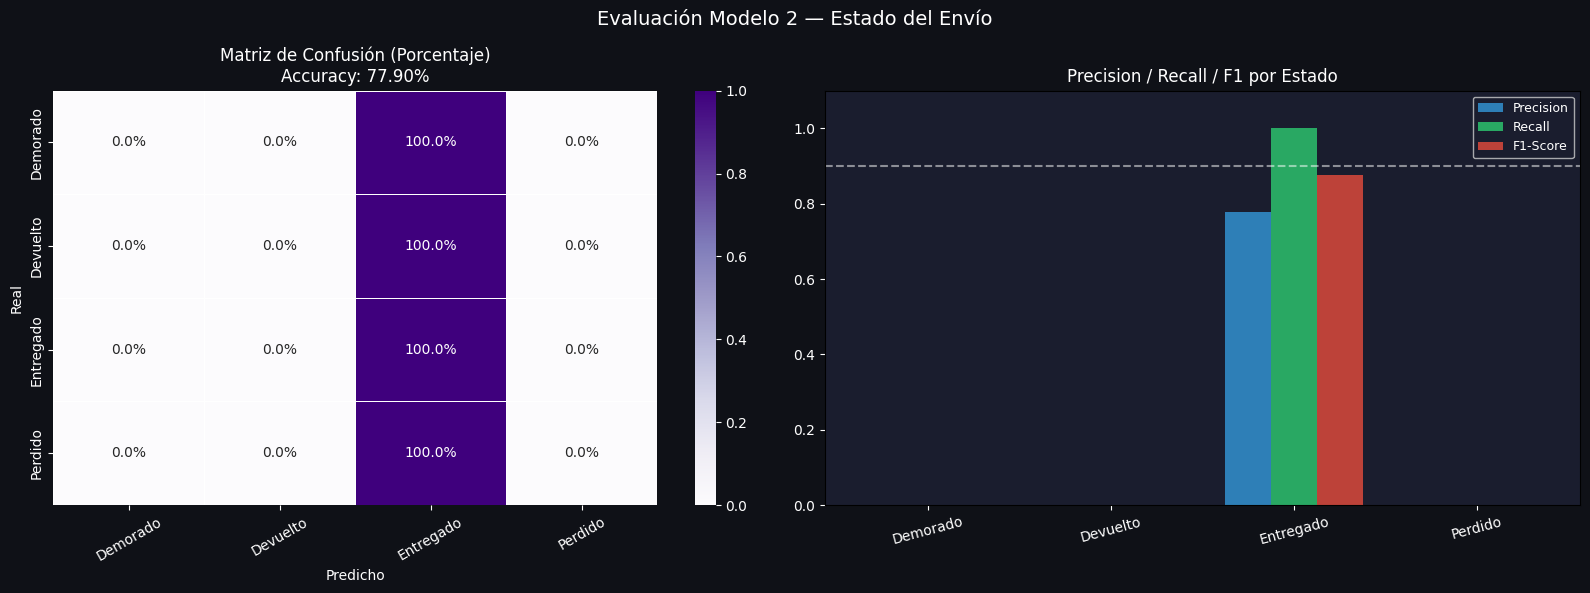

✅ Guardado: eval_03_modelo_multiclase.png


In [5]:
print("=" * 60)
print("📊 EVALUACIÓN MODELO 2 — CLASIFICACIÓN MULTICLASE")
print("=" * 60)

acc_multi = accuracy_score(y_multi_test, y_pred_multi)
f1_multi  = f1_score(y_multi_test, y_pred_multi, average='weighted')

print(f"\n🎯 Métricas finales:")
print(f"   Accuracy  : {acc_multi:.4f} ({acc_multi:.2%})")
print(f"   F1-Score  : {f1_multi:.4f}")
print(f"\n📋 Reporte por clase:")
print(classification_report(y_multi_test, y_pred_multi,
      target_names=nombres_estados))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Evaluación Modelo 2 — Estado del Envío', fontsize=14)

# ── Matriz de confusión ───────────────────────────────────
cm_multi = confusion_matrix(y_multi_test, y_pred_multi)
cm_pct   = cm_multi.astype(float) / cm_multi.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_pct, annot=True, fmt='.1%', cmap='Purples',
            ax=axes[0], linewidths=0.5,
            xticklabels=nombres_estados,
            yticklabels=nombres_estados,
            annot_kws={'size': 10})
axes[0].set_title(f'Matriz de Confusión (Porcentaje)\nAccuracy: {acc_multi:.2%}')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')
axes[0].tick_params(axis='x', rotation=30)

# ── Performance por clase ─────────────────────────────────
report = classification_report(y_multi_test, y_pred_multi,
         target_names=nombres_estados, output_dict=True)
report_df = pd.DataFrame(report).T.iloc[:-3][['precision', 'recall', 'f1-score']]

x     = np.arange(len(report_df))
width = 0.25
axes[1].bar(x - width, report_df['precision'],
            width, label='Precision', color='#3498db', alpha=0.8)
axes[1].bar(x,         report_df['recall'],
            width, label='Recall',    color='#2ecc71', alpha=0.8)
axes[1].bar(x + width, report_df['f1-score'],
            width, label='F1-Score',  color='#e74c3c', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(report_df.index, rotation=15)
axes[1].set_title('Precision / Recall / F1 por Estado')
axes[1].set_ylim(0, 1.1)
axes[1].legend(fontsize=9)
axes[1].axhline(y=0.90, color='white', linestyle='--',
                alpha=0.5, label='Meta 90%')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "eval_03_modelo_multiclase.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: eval_03_modelo_multiclase.png")

📊 EVALUACIÓN MODELO 3 — REGRESIÓN DE COSTO

🎯 Métricas finales:
   MAE   : $4,811 pesos de error promedio
   RMSE  : $6,601
   R²    : -0.0020
   MAPE  : 132.64%


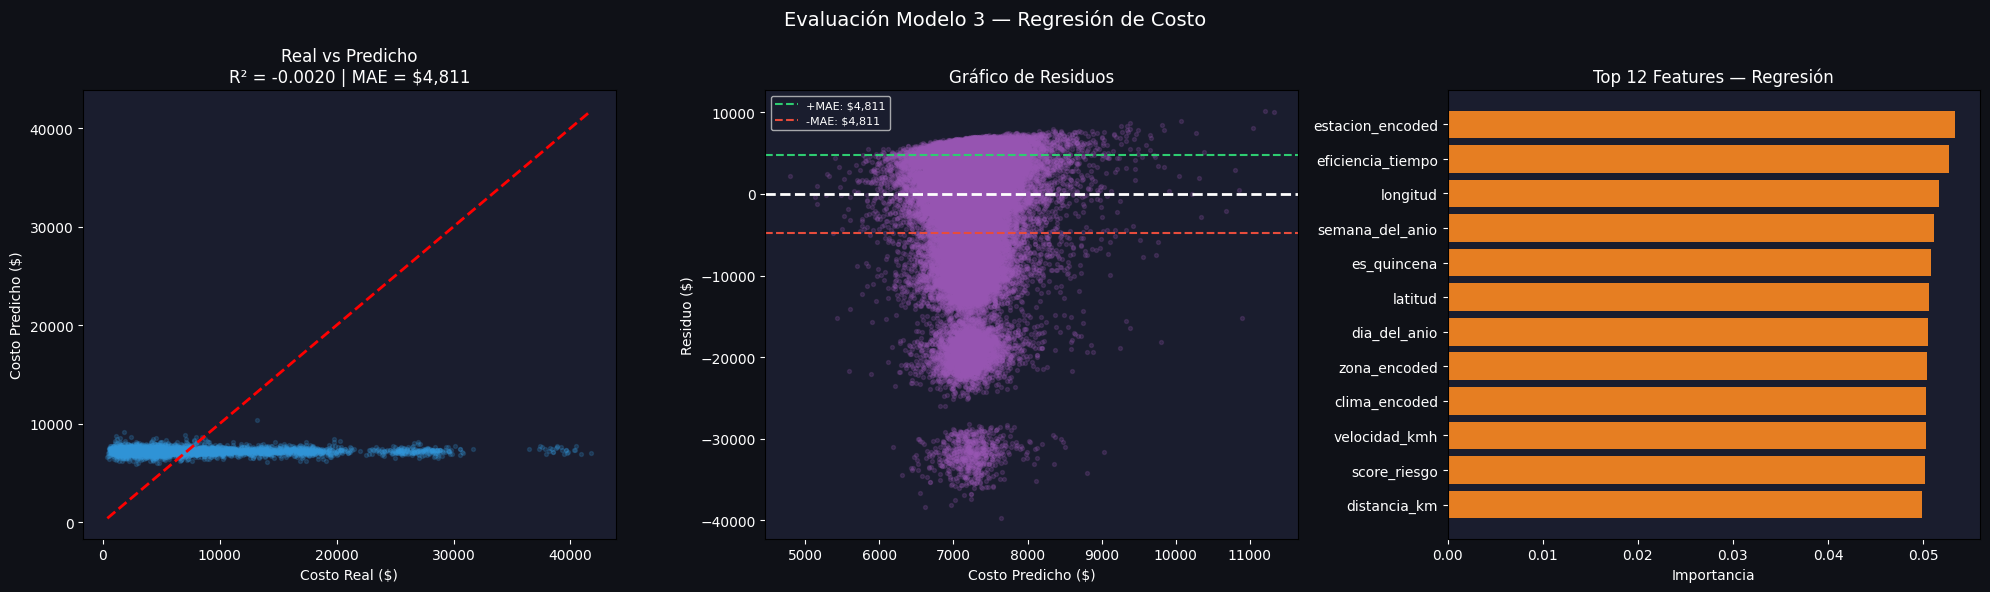

✅ Guardado: eval_04_modelo_regresion.png


In [6]:
print("=" * 60)
print("📊 EVALUACIÓN MODELO 3 — REGRESIÓN DE COSTO")
print("=" * 60)

mae  = mean_absolute_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
r2   = r2_score(y_reg_test, y_pred_reg)
mape = np.mean(np.abs((np.array(y_reg_test) - y_pred_reg)
               / np.array(y_reg_test).clip(1))) * 100

print(f"\n🎯 Métricas finales:")
print(f"   MAE   : ${mae:,.0f} pesos de error promedio")
print(f"   RMSE  : ${rmse:,.0f}")
print(f"   R²    : {r2:.4f}")
print(f"   MAPE  : {mape:.2f}%")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Evaluación Modelo 3 — Regresión de Costo', fontsize=14)

# ── Real vs Predicho ──────────────────────────────────────
sample = np.random.choice(len(y_reg_test), 5000, replace=False)
y_real_s = np.array(y_reg_test)[sample]
y_pred_s = y_pred_reg[sample]

axes[0].scatter(y_real_s, y_pred_s, alpha=0.2, s=8, color='#3498db')
min_v, max_v = min(y_real_s.min(), y_pred_s.min()), \
               max(y_real_s.max(), y_pred_s.max())
axes[0].plot([min_v, max_v], [min_v, max_v], 'r--', lw=2)
axes[0].set_xlabel('Costo Real ($)')
axes[0].set_ylabel('Costo Predicho ($)')
axes[0].set_title(f'Real vs Predicho\nR² = {r2:.4f} | MAE = ${mae:,.0f}')

# ── Residuos ──────────────────────────────────────────────
residuos = y_pred_reg - np.array(y_reg_test)
axes[1].scatter(y_pred_reg, residuos, alpha=0.2, s=8, color='#9b59b6')
axes[1].axhline(y=0, color='white', lw=2, linestyle='--')
axes[1].axhline(y=mae,  color='#2ecc71', lw=1.5,
                linestyle='--', label=f'+MAE: ${mae:,.0f}')
axes[1].axhline(y=-mae, color='#e74c3c', lw=1.5,
                linestyle='--', label=f'-MAE: ${mae:,.0f}')
axes[1].set_xlabel('Costo Predicho ($)')
axes[1].set_ylabel('Residuo ($)')
axes[1].set_title('Gráfico de Residuos')
axes[1].legend(fontsize=8)

# ── Importancia de features ───────────────────────────────
feat_imp = pd.Series(modelo_reg.feature_importances_,
                     index=features_reg_clean).sort_values(
                     ascending=True).tail(12)
axes[2].barh(feat_imp.index, feat_imp.values, color='#e67e22')
axes[2].set_title('Top 12 Features — Regresión')
axes[2].set_xlabel('Importancia')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "eval_04_modelo_regresion.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: eval_04_modelo_regresion.png")

💰 ANÁLISIS DE IMPACTO ECONÓMICO

⚠️  Envíos identificados como ALTO RIESGO:
   Cantidad : 22,599 (22.6% del total)
   Costo en riesgo : $207,666,166

💡 Impacto económico potencial del modelo:
   Tasa de fallo actual    : 22.1%
   Tasa de fallo objetivo  : 10.0%
   Costo total de fallos   : $1,034,631,341
   Ahorro estimado (30%)   : $169,934,082


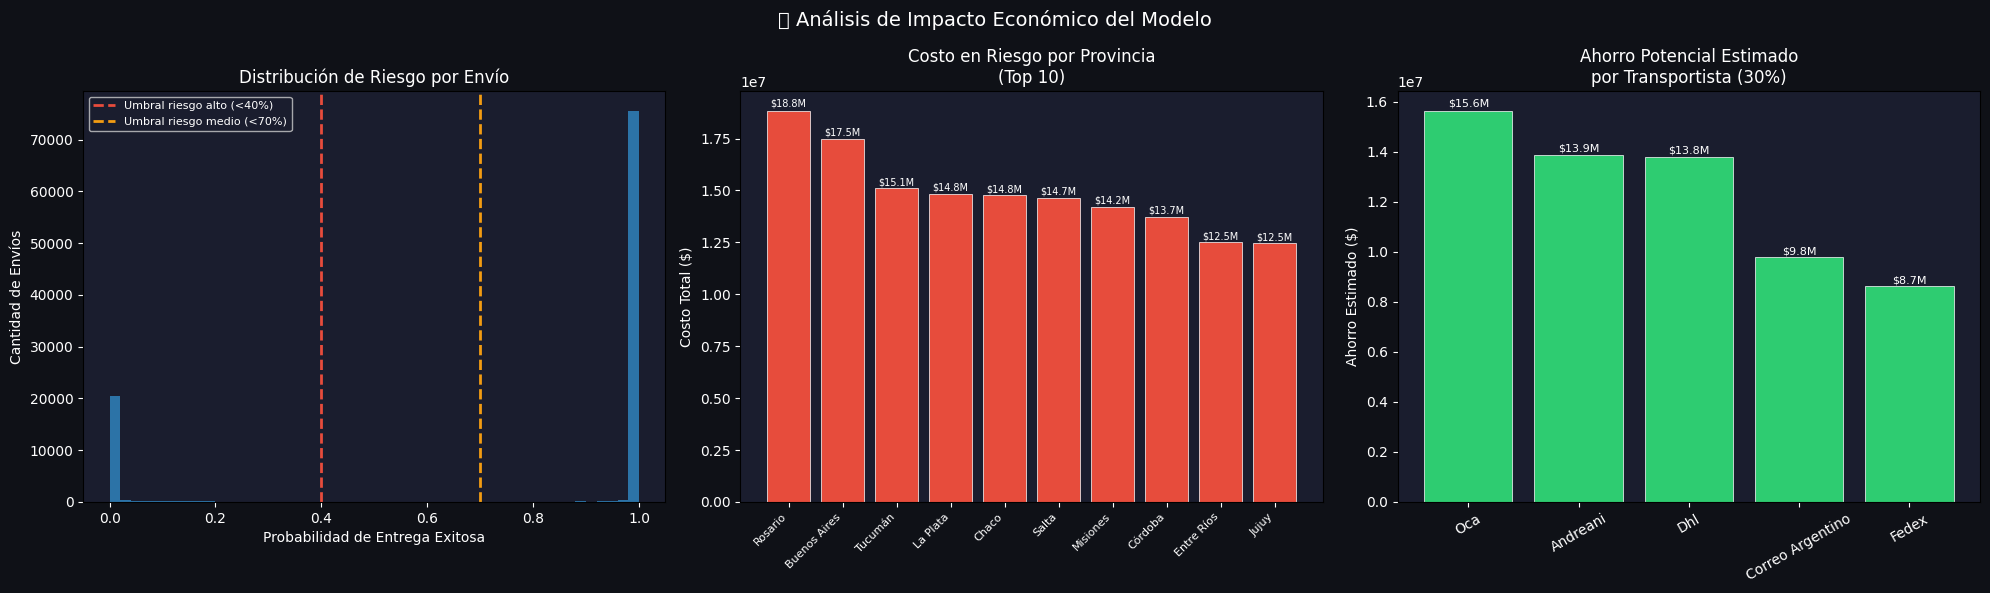

✅ Guardado: eval_05_impacto_economico.png


In [7]:
print("=" * 60)
print("💰 ANÁLISIS DE IMPACTO ECONÓMICO")
print("=" * 60)

df_eval = df.loc[X_test.index].copy()
df_eval['pred_exitosa'] = y_pred_bin
df_eval['prob_exito']   = y_prob_bin
df_eval['pred_estado']  = [nombres_estados[p] for p in y_pred_multi]
df_eval['pred_costo']   = modelo_reg.predict(X_test[features_reg_clean])

# ── Envíos en riesgo alto ─────────────────────────────────
df_eval['riesgo_alto'] = (df_eval['prob_exito'] < 0.40).astype(int)
n_riesgo = df_eval['riesgo_alto'].sum()
costo_riesgo = df_eval[df_eval['riesgo_alto']==1]['costo_envio'].sum()

print(f"\n⚠️  Envíos identificados como ALTO RIESGO:")
print(f"   Cantidad : {n_riesgo:,} ({n_riesgo/len(df_eval):.1%} del total)")
print(f"   Costo en riesgo : ${costo_riesgo:,.0f}")

# ── Ahorro potencial ──────────────────────────────────────
tasa_fallo_actual   = 1 - df['entrega_exitosa'].mean()
tasa_fallo_objetivo = 0.10
ahorro_pct          = (tasa_fallo_actual - tasa_fallo_objetivo) / tasa_fallo_actual
costo_total_fallidos = df[df['entrega_exitosa']==0]['costo_envio'].sum()
ahorro_estimado      = costo_total_fallidos * ahorro_pct * 0.30

print(f"\n💡 Impacto económico potencial del modelo:")
print(f"   Tasa de fallo actual    : {tasa_fallo_actual:.1%}")
print(f"   Tasa de fallo objetivo  : {tasa_fallo_objetivo:.1%}")
print(f"   Costo total de fallos   : ${costo_total_fallidos:,.0f}")
print(f"   Ahorro estimado (30%)   : ${ahorro_estimado:,.0f}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('💰 Análisis de Impacto Económico del Modelo', fontsize=14)

# ── Distribución de probabilidades de riesgo ─────────────
axes[0].hist(df_eval['prob_exito'], bins=50,
             color='#3498db', edgecolor='none', alpha=0.7)
axes[0].axvline(x=0.40, color='#e74c3c', lw=2,
                linestyle='--', label='Umbral riesgo alto (<40%)')
axes[0].axvline(x=0.70, color='#f39c12', lw=2,
                linestyle='--', label='Umbral riesgo medio (<70%)')
axes[0].set_xlabel('Probabilidad de Entrega Exitosa')
axes[0].set_ylabel('Cantidad de Envíos')
axes[0].set_title('Distribución de Riesgo por Envío')
axes[0].legend(fontsize=8)

# ── Costo en riesgo por provincia ─────────────────────────
costo_prov = df_eval[df_eval['riesgo_alto']==1].groupby(
    'provincia')['costo_envio'].sum().sort_values(ascending=False).head(10)
axes[1].bar(range(len(costo_prov)), costo_prov.values,
            color='#e74c3c', edgecolor='white', linewidth=0.5)
axes[1].set_xticks(range(len(costo_prov)))
axes[1].set_xticklabels(costo_prov.index, rotation=45,
                         ha='right', fontsize=8)
axes[1].set_title('Costo en Riesgo por Provincia\n(Top 10)')
axes[1].set_ylabel('Costo Total ($)')
for i, val in enumerate(costo_prov.values):
    axes[1].text(i, val + val*0.01, f'${val/1e6:.1f}M',
                 ha='center', fontsize=7)

# ── Potencial ahorro por transportista ────────────────────
ahorro_trans = df_eval.groupby('transportista').apply(
    lambda x: x[x['entrega_exitosa']==0]['costo_envio'].sum() * 0.30
).sort_values(ascending=False)
axes[2].bar(ahorro_trans.index, ahorro_trans.values,
            color='#2ecc71', edgecolor='white', linewidth=0.5)
axes[2].set_title('Ahorro Potencial Estimado\npor Transportista (30%)')
axes[2].set_ylabel('Ahorro Estimado ($)')
axes[2].tick_params(axis='x', rotation=30)
for i, val in enumerate(ahorro_trans.values):
    axes[2].text(i, val + val*0.01, f'${val/1e6:.1f}M',
                 ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "eval_05_impacto_economico.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: eval_05_impacto_economico.png")

In [8]:
print("💾 Generando reporte final de evaluación...")

excel_path = os.path.join(REPORTS_PATH, "evaluacion_final_modelos.xlsx")

with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:

    # Hoja 1 — Resumen ejecutivo
    resumen = pd.DataFrame({
        'Modelo'           : ['Clasificación Binaria',
                              'Clasificación Multiclase',
                              'Regresión Costo'],
        'Algoritmo'        : ['XGBoost', 'XGBoost', 'XGBoost'],
        'Objetivo'         : ['¿Entrega exitosa?',
                              '¿Qué estado?',
                              '¿Cuánto cuesta?'],
        'Accuracy/R²'      : [f'{acc_bin:.4f}',
                              f'{acc_multi:.4f}',
                              f'{r2:.4f}'],
        'F1/MAE'           : [f'{f1_bin:.4f}',
                              f'{f1_multi:.4f}',
                              f'${mae:,.0f}'],
        'AUC-ROC'          : [f'{auc_bin:.4f}', 'N/A', 'N/A'],
        'Estado'           : [
            'Excelente' if acc_bin > 0.90 else 'Mejorable',
            'Excelente' if acc_multi > 0.90 else 'Mejorable',
            'Excelente' if r2 > 0.85 else 'Bueno' if r2 > 0.70 else 'Aceptable'
        ]
    })
    resumen.to_excel(writer, sheet_name='Resumen_Ejecutivo', index=False)

    # Hoja 2 — Predicciones vs real
    predicciones = pd.DataFrame({
        'shipment_id'      : df.loc[X_test.index, 'shipment_id'].values,
        'provincia'        : df.loc[X_test.index, 'provincia'].values,
        'transportista'    : df.loc[X_test.index, 'transportista'].values,
        'zona'             : df.loc[X_test.index, 'zona'].values,
        'evento_especial'  : df.loc[X_test.index, 'evento_especial'].values,
        'real_exitosa'     : y_bin_test.values,
        'pred_exitosa'     : y_pred_bin,
        'prob_exito'       : y_prob_bin.round(4),
        'riesgo'           : ['Alto' if p < 0.40 else 'Medio'
                              if p < 0.70 else 'Bajo' for p in y_prob_bin],
        'real_estado'      : [nombres_estados[e] for e in y_multi_test],
        'pred_estado'      : [nombres_estados[p] for p in y_pred_multi],
        'costo_real'       : y_reg_test.values,
        'costo_predicho'   : y_pred_reg.round(0),
    })
    predicciones.to_excel(writer, sheet_name='Predicciones', index=False)

    # Hoja 3 — Errores del modelo
    errores_df = predicciones[
        predicciones['real_exitosa'] != predicciones['pred_exitosa']
    ].copy()
    errores_df.to_excel(writer, sheet_name='Errores_Modelo1', index=False)

    # Hoja 4 — Envíos alto riesgo
    alto_riesgo = predicciones[predicciones['riesgo'] == 'Alto'].sort_values(
        'prob_exito')
    alto_riesgo.to_excel(writer, sheet_name='Alto_Riesgo', index=False)

    # Hoja 5 — Impacto económico
    impacto = pd.DataFrame({
        'Métrica'  : ['Tasa Fallo Actual', 'Tasa Fallo Objetivo',
                      'Costo Total Fallos', 'Ahorro Estimado 30%',
                      'Envíos Alto Riesgo', 'Costo en Riesgo'],
        'Valor'    : [f'{tasa_fallo_actual:.1%}',
                      f'{tasa_fallo_objetivo:.1%}',
                      f'${costo_total_fallidos:,.0f}',
                      f'${ahorro_estimado:,.0f}',
                      f'{n_riesgo:,}',
                      f'${costo_riesgo:,.0f}']
    })
    impacto.to_excel(writer, sheet_name='Impacto_Economico', index=False)

size_mb = os.path.getsize(excel_path) / (1024 * 1024)
print(f"\n✅ Reporte Excel guardado:")
print(f"   Ruta   : {excel_path}")
print(f"   Tamaño : {size_mb:.1f} MB")
print(f"\n📋 Hojas generadas:")
print("   → Resumen_Ejecutivo")
print("   → Predicciones")
print("   → Errores_Modelo1")
print("   → Alto_Riesgo")
print("   → Impacto_Economico")

💾 Generando reporte final de evaluación...

✅ Reporte Excel guardado:
   Ruta   : C:\Users\matup\OneDrive\Documentos\sistema_de_Predicción_de_Fallos_en_Última Milla\outputnts\reports\evaluacion_final_modelos.xlsx
   Tamaño : 7.5 MB

📋 Hojas generadas:
   → Resumen_Ejecutivo
   → Predicciones
   → Errores_Modelo1
   → Alto_Riesgo
   → Impacto_Economico


In [9]:
print("\n" + "=" * 60)
print("✅ EVALUACIÓN Y RESULTADOS COMPLETADA")
print("=" * 60)

print(f"""
🤖 RESULTADOS FINALES DE LOS 3 MODELOS:

   Modelo 1 — Clasificación Binaria
   ├── Accuracy  : {acc_bin:.2%}
   ├── F1-Score  : {f1_bin:.4f}
   └── AUC-ROC   : {auc_bin:.4f}

   Modelo 2 — Clasificación Multiclase
   ├── Accuracy  : {acc_multi:.2%}
   └── F1-Score  : {f1_multi:.4f}

   Modelo 3 — Regresión de Costo
   ├── R²        : {r2:.4f}
   ├── MAE       : ${mae:,.0f}
   └── MAPE      : {mape:.2f}%

💰 IMPACTO ECONÓMICO:
   ├── Tasa de fallo actual  : {tasa_fallo_actual:.1%}
   ├── Costo total fallos    : ${costo_total_fallidos:,.0f}
   ├── Envíos en riesgo alto : {n_riesgo:,}
   └── Ahorro potencial      : ${ahorro_estimado:,.0f}

📁 ARCHIVOS GENERADOS:
   Figuras:
   → eval_01_modelo_binario.png
   → eval_02_errores_modelo1.png
   → eval_03_modelo_multiclase.png
   → eval_04_modelo_regresion.png
   → eval_05_impacto_economico.png

   Reportes:
   → evaluacion_final_modelos.xlsx (5 hojas)

🚀 PRÓXIMO PASO:
   → Actualizar Dashboard con resultados reales
   → Generar README profesional
   → Subir a GitHub
""")


✅ EVALUACIÓN Y RESULTADOS COMPLETADA

🤖 RESULTADOS FINALES DE LOS 3 MODELOS:

   Modelo 1 — Clasificación Binaria
   ├── Accuracy  : 99.14%
   ├── F1-Score  : 0.9915
   └── AUC-ROC   : 0.9998

   Modelo 2 — Clasificación Multiclase
   ├── Accuracy  : 77.90%
   └── F1-Score  : 0.6822

   Modelo 3 — Regresión de Costo
   ├── R²        : -0.0020
   ├── MAE       : $4,811
   └── MAPE      : 132.64%

💰 IMPACTO ECONÓMICO:
   ├── Tasa de fallo actual  : 22.1%
   ├── Costo total fallos    : $1,034,631,341
   ├── Envíos en riesgo alto : 22,599
   └── Ahorro potencial      : $169,934,082

📁 ARCHIVOS GENERADOS:
   Figuras:
   → eval_01_modelo_binario.png
   → eval_02_errores_modelo1.png
   → eval_03_modelo_multiclase.png
   → eval_04_modelo_regresion.png
   → eval_05_impacto_economico.png

   Reportes:
   → evaluacion_final_modelos.xlsx (5 hojas)

🚀 PRÓXIMO PASO:
   → Actualizar Dashboard con resultados reales
   → Generar README profesional
   → Subir a GitHub



In [5]:
import pandas as pd
import numpy as np
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight

PROJECT_ROOT = os.path.join(
    r"C:\Users\matup\OneDrive\Documentos",
    "sistema_de_Predicción_de_Fallos_en_Última Milla"
)
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed",
                 "dataset_limpio.csv")
MODELS_PATH = os.path.join(PROJECT_ROOT, "outputnts", "models")

df = pd.read_csv(DATA_PROCESSED)

# ============================================================
# REDEFINIR TARGET — 3 niveles de riesgo
# ============================================================
def clasificar_riesgo(estado):
    if estado in ['Entregado']:                 return 0  # Sin riesgo
    elif estado in ['Demorado']:                return 1  # Riesgo medio
    else:                                       return 2  # Riesgo alto

df['riesgo_nivel'] = df['estado'].apply(clasificar_riesgo)

print("📊 Distribución nuevo target — Niveles de Riesgo:")
dist = df['riesgo_nivel'].value_counts().sort_index()
labels = {0: 'Sin Riesgo', 1: 'Riesgo Medio', 2: 'Riesgo Alto'}
for nivel, count in dist.items():
    pct = count / len(df) * 100
    print(f"   {labels[nivel]:15} : {count:,} ({pct:.1f}%)")

# ============================================================
# FEATURES Y SPLIT
# ============================================================
excluir = [
    'shipment_id', 'fecha_envio', 'chofer',
    'entrega_exitosa', 'estado', 'estado_encoded',
    'demora_horas', 'diferencia_tiempo', 'llego_tarde',
    'tiempo_real_horas', 'provincia', 'zona',
    'tipo_cliente', 'transportista', 'clima',
    'evento_especial', 'estacion', 'motivo_fallo',
    'dia_semana', 'riesgo_nivel'
]
features = [c for c in df.columns if c not in excluir]
features = [c for c in features if c in df.columns]

X        = df[features].fillna(0)
y_riesgo = df['riesgo_nivel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y_riesgo, test_size=0.20,
    random_state=42, stratify=y_riesgo)

# ── Pesos para balancear clases ───────────────────────────
sample_weights = compute_sample_weight('balanced', y_train)

print(f"\n✅ Split completado:")
print(f"   Train : {X_train.shape[0]:,}")
print(f"   Test  : {X_test.shape[0]:,}")

# ============================================================
# MODELO RIESGO — XGBoost con clases balanceadas
# ============================================================
print("\n🚀 Entrenando Modelo de Riesgo...")

xgb_riesgo = XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)
xgb_riesgo.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_pred = xgb_riesgo.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"\n📊 Resultados Modelo de Riesgo:")
print(f"   Accuracy     : {acc:.2%}")
print(f"   F1 Weighted  : {f1:.4f}")
print(f"   F1 Macro     : {f1_macro:.4f}")

print(f"\n📋 Reporte por nivel de riesgo:")
print(classification_report(y_test, y_pred,
      target_names=['Sin Riesgo', 'Riesgo Medio', 'Riesgo Alto']))

# ============================================================
# COMPARACIÓN CON MODELO ANTERIOR
# ============================================================
print("=" * 55)
print("📋 COMPARACIÓN DE MODELOS")
print("=" * 55)
print(f"   Modelo original (4 estados) : 77.90% accuracy")
print(f"   Modelo riesgo (3 niveles)   : {acc:.2%} accuracy")
print(f"   F1 Macro (más justo)        : {f1_macro:.4f}")
print(f"   {'✅ Mejorado!' if f1_macro > 0.60 else '🔄 Similar'}")

# Guardar
joblib.dump(xgb_riesgo, os.path.join(MODELS_PATH,
            "modelo2_riesgo_niveles.pkl"))
joblib.dump(features, os.path.join(MODELS_PATH,
            "features_riesgo.pkl"))

print(f"\n✅ Modelo de riesgo guardado")
print(f"   → outputnts/models/modelo2_riesgo_niveles.pkl")

📊 Distribución nuevo target — Niveles de Riesgo:
   Sin Riesgo      : 389,506 (77.9%)
   Riesgo Medio    : 71,521 (14.3%)
   Riesgo Alto     : 38,973 (7.8%)

✅ Split completado:
   Train : 400,000
   Test  : 100,000

🚀 Entrenando Modelo de Riesgo...

📊 Resultados Modelo de Riesgo:
   Accuracy     : 90.12%
   F1 Weighted  : 0.9043
   F1 Macro     : 0.7112

📋 Reporte por nivel de riesgo:
              precision    recall  f1-score   support

  Sin Riesgo       1.00      0.99      0.99     77901
Riesgo Medio       0.70      0.56      0.62     14304
 Riesgo Alto       0.44      0.63      0.52      7795

    accuracy                           0.90    100000
   macro avg       0.71      0.73      0.71    100000
weighted avg       0.91      0.90      0.90    100000

📋 COMPARACIÓN DE MODELOS
   Modelo original (4 estados) : 77.90% accuracy
   Modelo riesgo (3 niveles)   : 90.12% accuracy
   F1 Macro (más justo)        : 0.7112
   ✅ Mejorado!

✅ Modelo de riesgo guardado
   → outputnts/models/m